In [1]:
from collections import deque
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy
from bbutils.utils import *
from tqdm import tqdm
%matplotlib inline

COLUMN_WIDTH = 3.25  # Inches
TEXT_WIDTH = 6.299213  # Inches
GOLDEN_RATIO = 1.61803398875
DPI = 300
FONT_SIZE = 8

mpl.rcParams['font.size'] = FONT_SIZE
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times']
# mpl.rcParams['text.usetex'] = True

mpl.rcParams['text.usetex'] = False
from bbutils import BetaBernoulli

In [2]:
category2idx = dict()
idx2category = []
categories = []
observations = []

with open('data/cifar100/predictions.txt', 'r') as f:
    next(f)
    for line in f:
        _, correct, predicted, confidence = line.split()
        if predicted not in category2idx:
            category2idx[predicted] = len(category2idx)
            idx2category.append(predicted)
        idx = category2idx[predicted]
        categories.append(idx)
        observations.append(correct == predicted)
num_classes = 100

In [3]:
# #### evil 
# for idx in range(len(categories)):
#     k = categories[idx]
#     observations[idx] = np.random.binomial(n=1, p=k/num_classes)

In [4]:
N = int(len(observations))
n_pool = np.array([(np.array(categories) == _).sum() for _ in range(num_classes)])
p_pool = n_pool / len(categories)
theta_prior = np.ones((num_classes,2))
theta_prior[:, 0] = 20
theta_prior[:, 1] = 80
num_runs = 100

In [5]:
random_choices = np.zeros((num_runs , N, 2))
active_choices = np.zeros((num_runs , N, 2))
random_models = [deepcopy(BetaBernoulli(num_classes, theta_prior)) for r in range(num_runs)]
active_models = [deepcopy(BetaBernoulli(num_classes, theta_prior)) for r in range(num_runs)]
overall_accuracy_random = np.zeros((num_runs, N))
overall_accuracy_active = np.zeros((num_runs, N))

for r in tqdm(range(num_runs)):
    
    ###### RANDOM SAMPLING
    deque_random = deepcopy(list(zip(categories, observations)))
    random.shuffle(deque_random)
    for i in range(N):
        category, observation = deque_random.pop()
        random_choices[r, i] = category, observation
        random_models[r].update(category, observation)
        #overall_accuracy_random[r, i] = random_choices[r, :i, 1].sum() / i
        overall_accuracy_random[r, i] = random_models[r].get_overall_acc(p_pool, theta_prior)
        
    ###### OPTIMAL SAMPLING
    deques = prepare_deques(categories, observations, num_classes)        
    for i in range(N):
        # thompson sampling
        theta_hat = active_models[r].sample()
        params = active_models[r].get_params()
        alpha, beta = params[:, 0], params[:,1]
        var_n_plus_1 = (alpha * (beta+1) - theta_hat * (alpha - beta)) / \
                        ((alpha + beta + 1) * (alpha + beta + 1) * (alpha + beta + 2))
        var_n  = active_models[r].get_variance()
        reward = p_pool * p_pool * (var_n_plus_1 - var_n) # minimize
        choices = np.argsort(reward)
        for j in range(num_classes):
            category = choices[j]
            if len(deques[category]) != 0:
                break
        observation = deques[category].pop()
        active_models[r].update(category, observation)
        active_choices[r, i] = category, observation
        overall_accuracy_active[r, i] = active_models[r].get_overall_acc(p_pool, theta_prior)

100%|██████████| 100/100 [11:03<00:00,  5.44s/it]


(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.]),
 <a list of 8 Text xticklabel objects>)

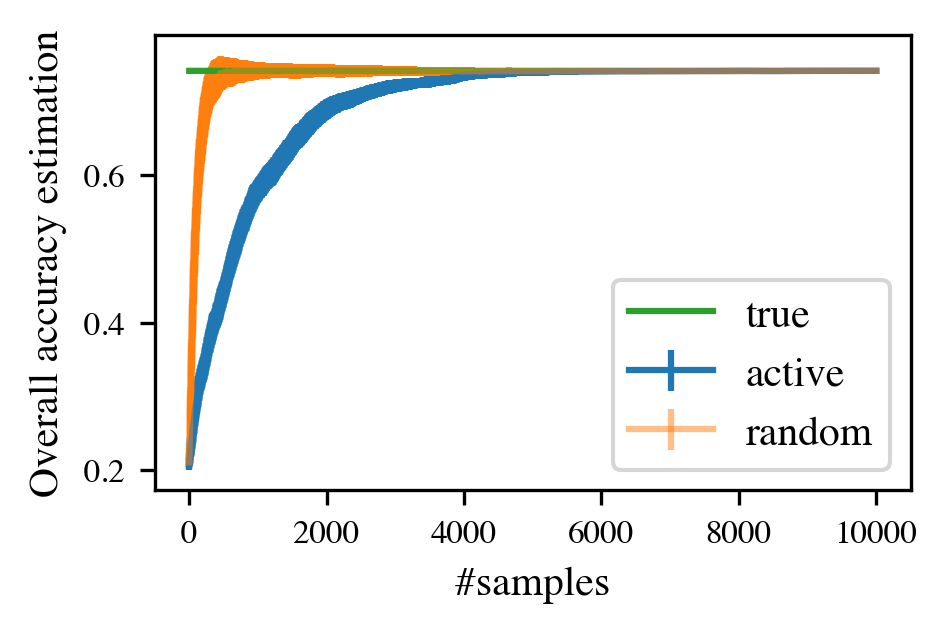

In [10]:
# If labels are getting cut off make the figsize smaller
plt.figure(figsize=(COLUMN_WIDTH, COLUMN_WIDTH / GOLDEN_RATIO), dpi=300)

n_plot = N-1
true_accuracy = sum(observations) / len(observations)

## PLOT STUFF ##
accuracy_active_mean = overall_accuracy_active.mean(axis = 0)[1:]
accuracy_active_err = np.std(overall_accuracy_active, axis=0)[1:]
accuracy_random_mean = overall_accuracy_random.mean(axis = 0)[1:]
accuracy_random_err = np.std(overall_accuracy_random, axis=0)[1:]
plt.errorbar([i for i in range(1, n_plot+1)], accuracy_active_mean[:n_plot], 
                 yerr = accuracy_active_err[:n_plot], label='active', alpha = 1.0)
plt.errorbar([i for i in range(1, n_plot+1)], accuracy_random_mean[:n_plot], 
                 yerr = accuracy_random_err[:n_plot], label='random', alpha = 0.5)
plt.plot([i for i in range(1, n_plot+1)], [true_accuracy for i in range(1, n_plot+1)], label='true')
plt.xlabel('#samples')
plt.ylabel('Overall accuracy estimation')
plt.legend()

# FORMAT STUFF ##
plt.yticks(fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE)

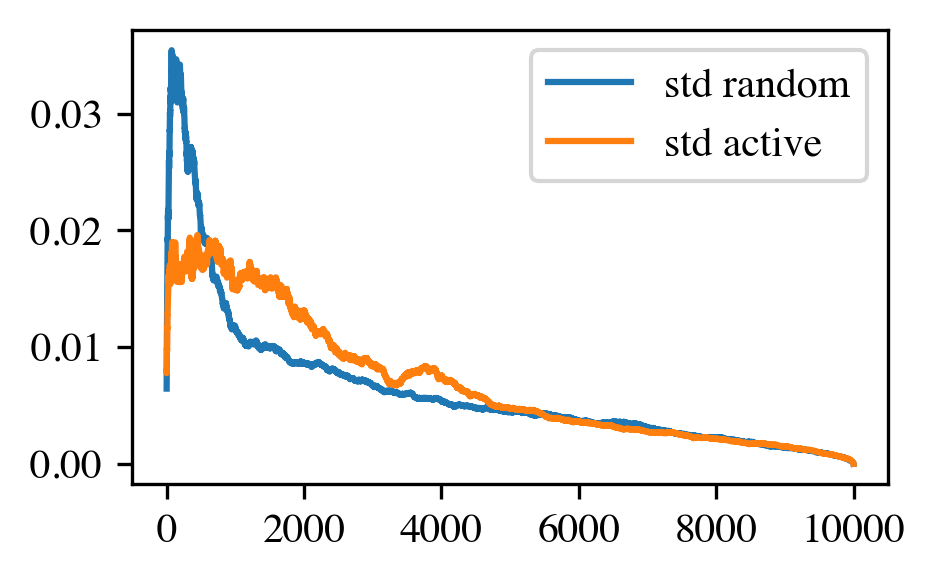

In [7]:
plt.figure(figsize=(COLUMN_WIDTH, COLUMN_WIDTH / GOLDEN_RATIO), dpi=300)
plt.plot(accuracy_random_err, label="std random")
plt.plot(accuracy_active_err, label="std active")
plt.legend()
plt.show()

In [8]:
p_pool.sum()

1.0

In [9]:
true_accuracy = sum(observations) / len(observations)